In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import os
import sys
import copy
from tqdm import tqdm

# Add src to path
sys.path.append("src")
import kmeans
import utils

## Jupyter notebooks settings.

# Reload modules before executing each cell.
%load_ext autoreload
%autoreload 2 

# Introduction

In this lab  we segment the given image using K-means clustering.

## Theory and implementation


## Code organization
**Date**: `data`

**Source code**: `src`

# Result

### Import data and visualize.

In [44]:
car = cv.imread('data/car.png')
flower = cv.imread('data/flower.png')
imgs = [car, flower]
img_names = ['car', 'flower']
c_init_1 = [[255, 0, 0], [0, 0, 0], [255, 255, 255]]

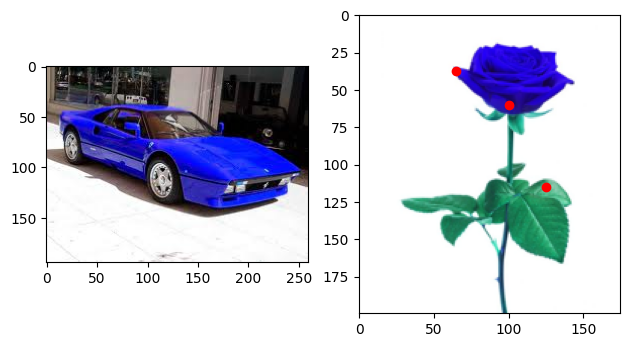

In [26]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(imgs[0])
axs[1].imshow(imgs[1])
axs[1].plot([65], [37], 'o', color='red')
axs[1].plot([100], [60], 'o', color='red')
axs[1].plot([125], [115], 'o', color='red')
fig.tight_layout()

In [28]:
print(flower[37, 65])
print(flower[60, 100])
print(flower[115, 125])
p1 = flower[37, 65]
p2 = flower[60, 100]
p3 = flower[115, 125]
print(np.linalg.norm(p1 - p2))
print(np.linalg.norm(p2 - p3))

[ 49  26 236]
[ 38  14 166]
[ 76 168 125]
71.8679344353238
244.14954433707223


In [3]:
imgs_segmented = []
for img in imgs:
    img_arr = utils.get_pixel_array(img)
    # c_init = np.array([[255, 255, 255], [15, 50, 120], [100, 200, 100]]).T
    c_init = np.array([[255, 255, 255], [15, 50, 120], [100, 200, 100]]).T
    cluster_assignment, clusters, cost = kmeans.kmeans(img_arr, 3, c_init)
    for i in range(img_arr.shape[1]):
        img_arr[:, i] = clusters[:, cluster_assignment[i]]
    img_segmented = utils.get_image(img_arr, img.shape[0], img.shape[1])
    imgs_segmented.append(img_segmented)

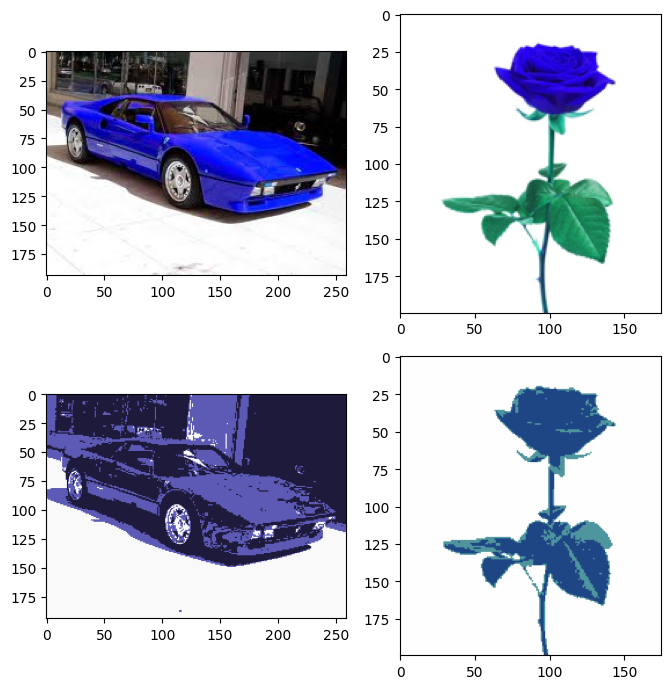

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
axs[0, 0].imshow(imgs[0])
axs[0, 1].imshow(imgs[1])
axs[1, 0].imshow(imgs_segmented[0])
axs[1, 1].imshow(imgs_segmented[1])
fig.tight_layout()
fig.savefig('data/output_a.png')

### Part-b: K-means by random clustering

In [5]:
imgs_segmented = []
mincost_cluster_assignment, mincost_clusters, mincost = [], [], np.inf
costs_imgs = []
for img in imgs:
    costs_img = []
    img_arr = utils.get_pixel_array(img)
    for i in tqdm(range(30)):
        cluster_assignment, clusters, cost = kmeans.kmeans(img_arr, 3)
        costs_img.append(cost)
        if cost < mincost:
            mincost_cluster_assignment, mincost_clusters, mincost = cluster_assignment, clusters, cost
    for i in range(img_arr.shape[1]):
        img_arr[:, i] = mincost_clusters[:, mincost_cluster_assignment[i]]
    costs_imgs.append(costs_img)
    img_segmented = utils.get_image(img_arr, img.shape[0], img.shape[1])
    imgs_segmented.append(img_segmented)

100%|██████████| 30/30 [04:41<00:00,  9.40s/it]


In [11]:
costs_imgs[0]

[1129221147.788715,
 1129221147.788715,
 5167517663.063228,
 1129221147.788715,
 1129221147.788715,
 1129221147.788715,
 1129221147.788715,
 1128907643.3238504,
 1129221147.788715,
 1129221147.788715,
 1129221147.788715,
 1128907643.3238504,
 1129221147.788715,
 1129221147.788715,
 1128907643.3238504,
 1129221147.788715,
 1129221147.788715,
 1129221147.788715,
 1129221147.788715,
 1129221147.788715,
 1129221147.788715,
 1128907643.3238504,
 1129221147.788715,
 1128907643.3238504,
 1128907643.3238504,
 1129221147.788715,
 1129221147.788715,
 1129221147.788715,
 1129221147.788715,
 1129221147.788715]

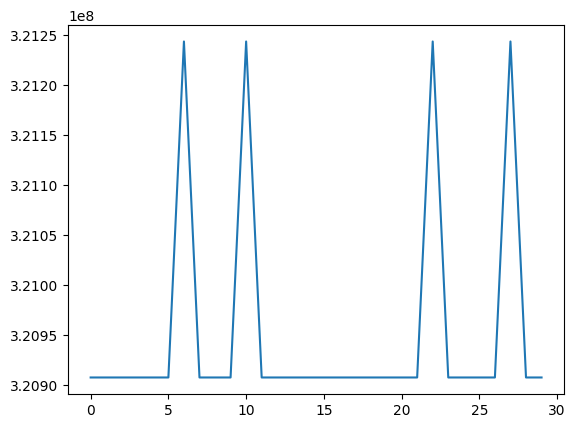

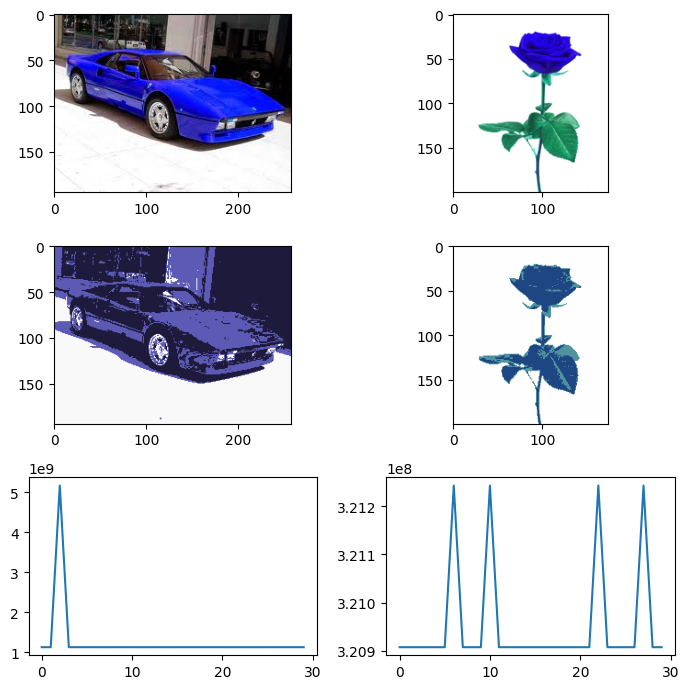

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(7, 7))
axs[0, 0].imshow(imgs[0])
axs[0, 1].imshow(imgs[1])
axs[1, 0].imshow(imgs_segmented[0])
axs[1, 1].imshow(imgs_segmented[1])
axs[2, 0].plot([i for i in range(30)], costs_imgs[0])
axs[2, 1].plot([i for i in range(30)], costs_imgs[1])

fig.tight_layout()
fig.savefig('data/output_b.png')

(194, 259, 3)


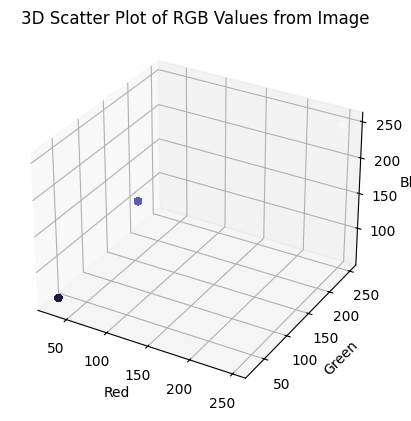

In [35]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Read the image using OpenCV
# image = cv2.imread('data/flower.png')
image = imgs_segmented[0]
print(image.shape)

# Reshape the image to a 1D array of RGB values
rgb_values = []

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        rgb_values.append(image[i, j])

rgb_values = np.array(rgb_values)

# Create 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract R, G, B values
r = rgb_values[:, 0]
g = rgb_values[:, 1]
b = rgb_values[:, 2]

ax.scatter(r, g, b, c=rgb_values / 255.0, marker='o')

# Set axis labels
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

plt.title('3D Scatter Plot of RGB Values from Image')
plt.show()


<Axes3D: title={'center': 'Cluster centers'}, xlabel='Red', ylabel='Green', zlabel='Blue'>

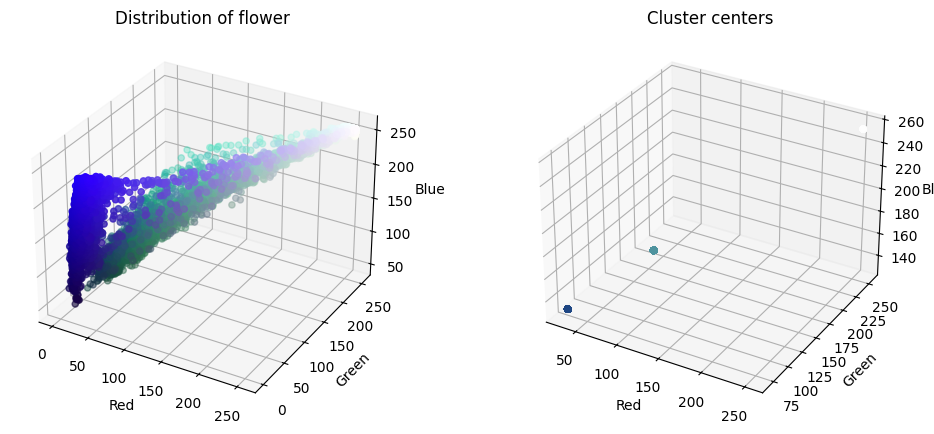

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': '3d'})
utils.plot_rgb(axs[0], flower, title='Distribution of flower')
utils.plot_rgb(axs[1], imgs_segmented[1], title='Cluster centers')